In [1]:
import pandas as pd
import numpy as np
import skimage
from skimage.io import imread
from tqdm import tqdm
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('Data/imputed_valid_data.pkl', 'rb') as picklefile:
    valid_data=pickle.load(picklefile)

with open('Data/imputed_train_data.pkl', 'rb') as picklefile:
    train_data=pickle.load(picklefile)

# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.995)
pca.fit(train_data.reshape(len(train_data),256*272))

In [ ]:
with open('Models/DR/trainedPCA.pkl', 'wb') as picklefile:
    pickle.dump(pca, picklefile)

In [ ]:
pcatest=pca.transform(valid_data.reshape(len(valid_data),256*272))

pcatest=pca.inverse_transform(pcatest)

pcatest=np.reshape(pcatest,(len(valid_data),256,272,1))

In [ ]:
plt.figure(figsize=(20,20))
# for i in range(n):
    # display original
# vd=np.expand_dims(valid_data[40],axis=0)
    
ax = plt.subplot(1,3,1)
plt.imshow(valid_data[40].reshape(256, 272),cmap='gray')
ax.set_title("Original",fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,3,2)
plt.imshow(abs(pcatest[40]).reshape(256, 272),cmap='gray')
ax.set_title("PCA",fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

# Auto Encoder

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU, ReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD

In [20]:
def create_model(f,loss,activation):
    
    inputs = Input(shape=(256, 272, 1), name="inputs")
    x = inputs
    
    x = Conv2D(8, (f,f), padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D((2,2))(x)

    x = Conv2D(16, (f,f), padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

    skip_x = x

    x = Conv2D(16, (f,f), padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.add([x, skip_x])
    x = MaxPool2D((2,2))(x)

    x = Conv2D(32, (f,f), padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

    skip_x1 = x

    x = Conv2D(32, (f,f), padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.add([x, skip_x1])
    x = MaxPool2D((2,2))(x)

    x = Conv2D(32, (f,f), padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D((2,2))(x)

    x = Conv2D(16, (f,f), padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(8, (f,f), padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(4, (f,f), padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(2, (f,f), padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
    latent = Flatten()(x)
    
    encoder = Model(inputs, latent)
    
    
    encoded_input =  Input(shape=(544), name="encoded")
    x = Reshape((16,17,2))(encoded_input)
    

    x = Conv2DTranspose(4, (f,f),strides=1, padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(8, (f,f),strides=1, padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(16, (f,f),strides=1, padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(32, (f,f),strides=2, padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

    skip_x2 = x

    x = Conv2DTranspose(32, (f,f),strides=1, padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = tf.keras.layers.add([x, skip_x2])
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(16,(f,f), strides=2, padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

    skip_x3 = x

    x = Conv2DTranspose(16,(f,f), strides=1, padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = tf.keras.layers.add([x, skip_x3])
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(8,(f,f), strides=2, padding="same",activation='elu')(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(1,(f,f), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation, name="outputs")(x)
    if activation=='tanh':
        x = 0.5*x + 0.5 
    outputs = x
    
    decoder = Model(encoded_input, outputs)
    
    _inputs = Input(shape=(256, 272, 1), name="inputs")
    compressed = encoder(_inputs)
    reconstruction = decoder(compressed)
    
    autoencoder = Model(_inputs, reconstruction)
    autoencoder.compile(optimizer=Adam(1e-3), loss=loss)
    return autoencoder,encoder,decoder

In [21]:
s_ae3,s_e3,s_d3 =create_model(3,'binary_crossentropy','sigmoid')
r_ae3,r_e3,r_d3 =create_model(3,tf.keras.losses.MeanAbsoluteError(),'relu')
t_ae3,t_e3,t_d3 =create_model(5,tf.keras.losses.MeanAbsoluteError(),'tanh')

In [19]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 2e-3 * 0.95 ** x)

In [22]:
history_s_ae3 = s_ae3.fit(train_data,train_data,epochs=50,batch_size=32,shuffle=False,
    validation_data=(valid_data,valid_data),verbose=2,steps_per_epoch=len(train_data) // 32,callbacks=[reduce_lr])
history_r_ae3= r_ae3.fit(train_data,train_data,epochs=50,batch_size=32,shuffle=False,
    validation_data=(valid_data,valid_data),verbose=2,steps_per_epoch=len(train_data) // 32,callbacks=[reduce_lr])
history_t_ae3= t_ae3.fit(train_data,train_data,epochs=50,batch_size=32,shuffle=False,
        validation_data=(valid_data,valid_data),verbose=2,steps_per_epoch=len(train_data) // 32,callbacks=[reduce_lr])

Epoch 1/50
51/51 - 13s - loss: 0.6524 - val_loss: 0.5370 - lr: 0.0020
Epoch 2/50
51/51 - 8s - loss: 0.5756 - val_loss: 0.5058 - lr: 0.0019
Epoch 3/50
51/51 - 8s - loss: 0.5384 - val_loss: 0.4875 - lr: 0.0018
Epoch 4/50
51/51 - 9s - loss: 0.5091 - val_loss: 0.4637 - lr: 0.0017
Epoch 5/50
51/51 - 8s - loss: 0.4812 - val_loss: 0.4448 - lr: 0.0016
Epoch 6/50
51/51 - 8s - loss: 0.4578 - val_loss: 0.4242 - lr: 0.0015
Epoch 7/50
51/51 - 8s - loss: 0.4380 - val_loss: 0.4055 - lr: 0.0015
Epoch 8/50
51/51 - 8s - loss: 0.4206 - val_loss: 0.3846 - lr: 0.0014
Epoch 9/50
51/51 - 9s - loss: 0.4044 - val_loss: 0.3682 - lr: 0.0013
Epoch 10/50
51/51 - 9s - loss: 0.3892 - val_loss: 0.3575 - lr: 0.0013
Epoch 11/50
51/51 - 8s - loss: 0.3779 - val_loss: 0.4096 - lr: 0.0012
Epoch 12/50
51/51 - 8s - loss: 0.3668 - val_loss: 0.3414 - lr: 0.0011
Epoch 13/50
51/51 - 9s - loss: 0.3568 - val_loss: 0.3334 - lr: 0.0011
Epoch 14/50
51/51 - 8s - loss: 0.3486 - val_loss: 0.3561 - lr: 0.0010
Epoch 15/50
51/51 - 9s - los

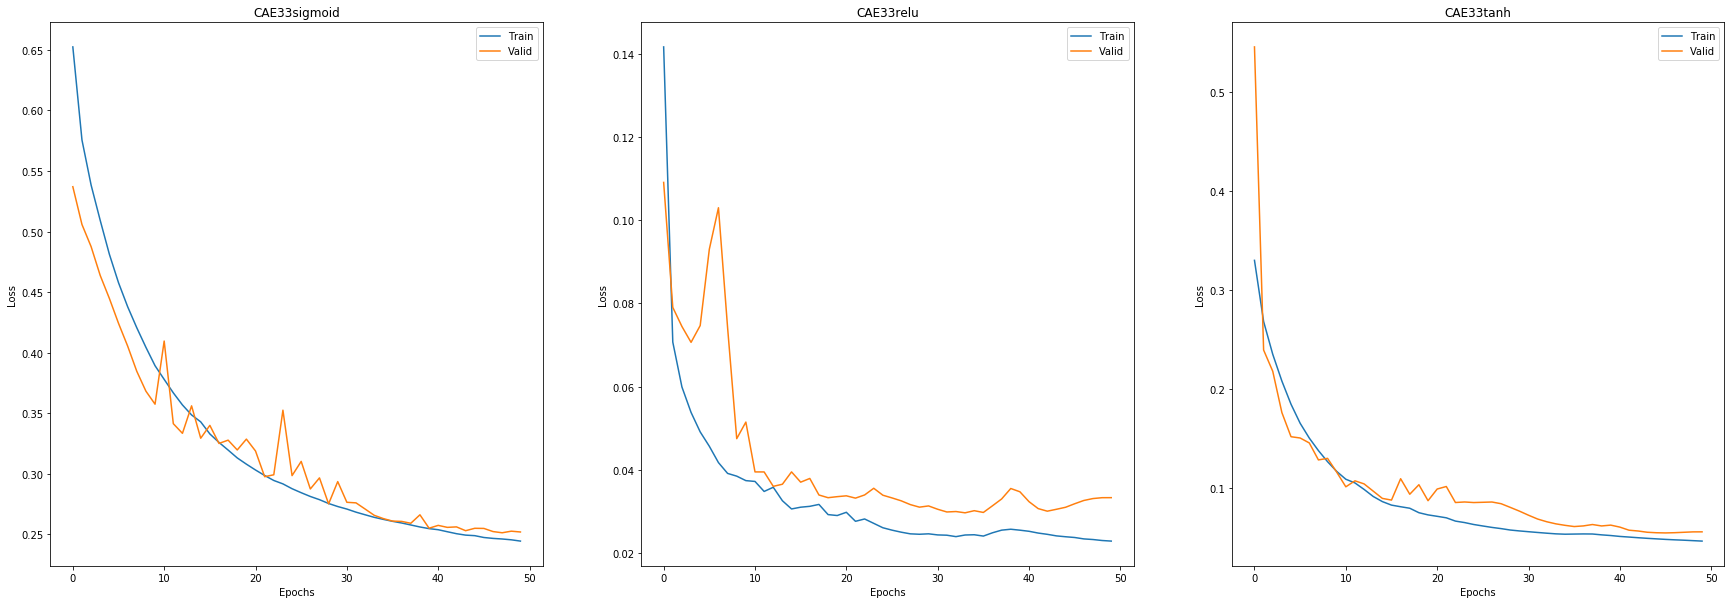

In [25]:
plt.figure(figsize=(30,10))
    
ax = plt.subplot(1,3,1)
plt.plot(history_s_ae3.history['loss'])
plt.plot(history_s_ae3.history['val_loss'])
ax.set_title("CAE33sigmoid")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(['Train', 'Valid'])
# plt.imshow()

ax = plt.subplot(1,3,2)
plt.plot(history_r_ae3.history['loss'])
plt.plot(history_r_ae3.history['val_loss'])
ax.set_title("CAE33relu")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(['Train', 'Valid'])
# plt.imshow()

ax = plt.subplot(1,3,3)
plt.plot(history_t_ae3.history['loss'])
plt.plot(history_t_ae3.history['val_loss'])
ax.set_title("CAE33tanh")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
# ax.set_ylim(0.2,0.8)
ax.legend(['Train', 'Valid'])
# plt.imshow()


In [26]:
s_d3.save("Models/DR/s_dec.h5")
s_e3.save("Models/DR/s_enc.h5")
s_ae3.save("Models/DR/s.h5")

r_d3.save("Models/DR/r_dec.h5")
r_e3.save("Models/DR/r_enc.h5")
r_ae3.save("Models/DR/r.h5")

t_d3.save("Models/DR/t_dec.h5")
t_e3.save("Models/DR/t_enc.h5")
t_ae3.save("Models/DR/t.h5")

In [12]:
s_ae3 = tf.keras.models.load_model('Models/DR/s.h5')
r_ae3 = tf.keras.models.load_model('Models/DR/r.h5')
t_ae3 = tf.keras.models.load_model('Models/DR/t.h5')

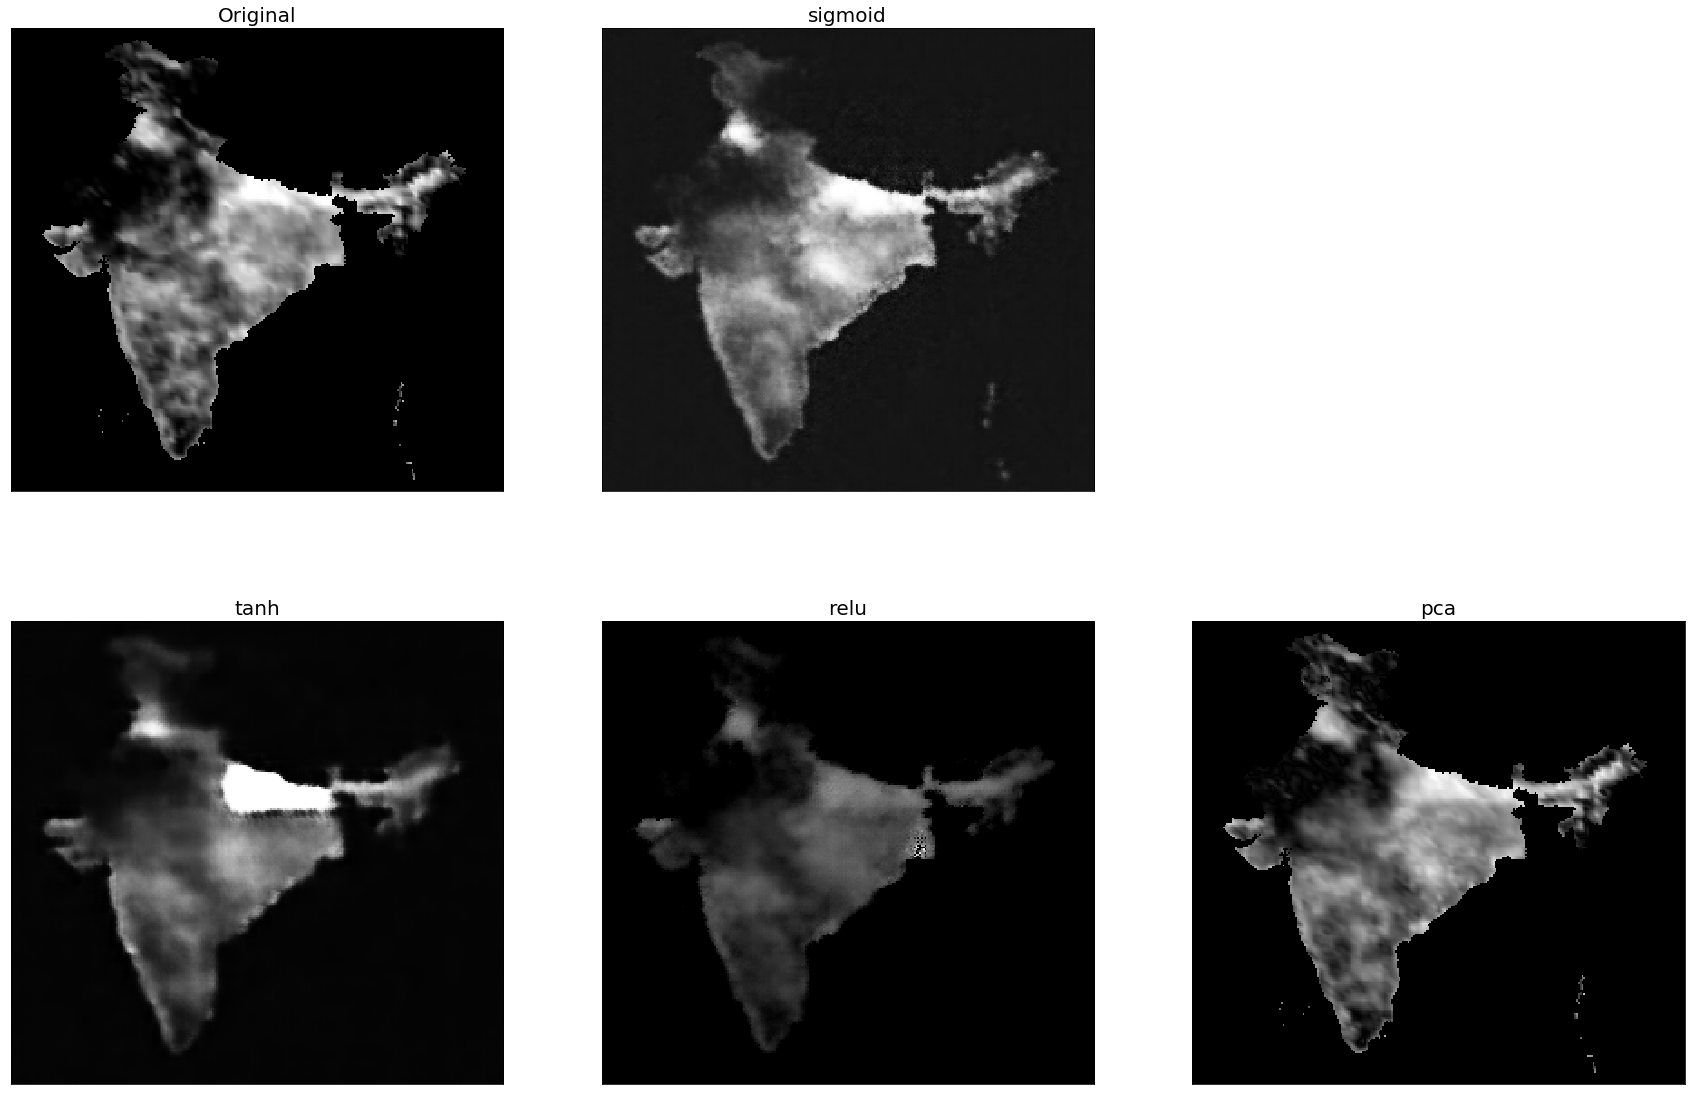

In [13]:
plt.figure(figsize=(30,20))
vd=np.expand_dims(valid_data[40],axis=0)
    
ax = plt.subplot(2,3,1)
plt.imshow(vd.reshape(256, 272),cmap='gray')
ax.set_title("Original",fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

se3=s_ae3.predict(vd)
ax = plt.subplot(2,3,2)
plt.imshow(se3.reshape(256, 272),cmap='gray')
ax.set_title("sigmoid",fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

te3=t_ae3.predict(vd)
ax = plt.subplot(2,3,4)
plt.imshow(te3.reshape(256, 272),cmap='gray')
ax.set_title("tanh",fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

re3=r_ae3.predict(vd)
ax = plt.subplot(2,3,5)
plt.imshow(re3.reshape(256, 272),cmap='gray')
ax.set_title("relu",fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,6)
plt.imshow(abs(pcatest[40]).reshape(256, 272),cmap='gray')
ax.set_title("pca",fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [14]:
from skimage.measure import compare_ssim as ssim
from sklearn.metrics import mean_absolute_error as mae

def SSIM(y_true, y_pred):
    return tf.reduce_mean(ssim(y_true, y_pred,multichannel=True))
def PSNR(y_true, y_pred):
    return (tf.image.psnr(y_true, y_pred, 1.0)).numpy().mean()

In [15]:
sig  = mae(valid_data.reshape(len(valid_data),256*272),s_ae3.predict(valid_data).reshape(len(valid_data),256*272))
print("Sigmoid AutoEncoder MAE score : ",sig)
rel  = mae(valid_data.reshape(len(valid_data),256*272),r_ae3.predict(valid_data).reshape(len(valid_data),256*272))
print("relu AutoEncoder MAE score : ",rel)
tan  = mae(valid_data.reshape(len(valid_data),256*272),t_ae3.predict(valid_data).reshape(len(valid_data),256*272))
print("tanh AutoEncoder MAE score : ",tan)
_pca= mae(valid_data.reshape(len(valid_data),256*272),pcatest.reshape(len(valid_data),256*272))
print("PCA AutoEncoder MAE score : ",_pca)

Sigmoid AutoEncoder MAE score :  0.11954829125676039
relu AutoEncoder MAE score :  0.03333337248834442
tanh AutoEncoder MAE score :  0.055173910818846976
PCA AutoEncoder MAE score :  0.009871804948725582


In [16]:
sig  = PSNR(valid_data,s_ae3.predict(valid_data))
print("Sigmoid AutoEncoder PSNR score : ",sig)
rel  = PSNR(valid_data,r_ae3.predict(valid_data))
print("relu AutoEncoder PSNR score : ",rel)
tan  = PSNR(valid_data,t_ae3.predict(valid_data))
print("tanh AutoEncoder PSNR score : ",tan)
_pca= PSNR(valid_data,pcatest)
print("PCA AutoEncoder PSNR score : ",_pca)

Sigmoid AutoEncoder PSNR score :  17.843163
relu AutoEncoder PSNR score :  21.373339
tanh AutoEncoder PSNR score :  20.370306
PCA AutoEncoder PSNR score :  32.230743


In [18]:
sig  = SSIM(valid_data,s_ae3.predict(valid_data)).numpy()
print("Sigmoid AutoEncoder SSIM score : ",sig)
rel  = SSIM(valid_data,r_ae3.predict(valid_data)).numpy()
print("relu AutoEncoder SSIM score : ",rel)
tan  = SSIM(valid_data,t_ae3.predict(valid_data)).numpy()
print("tanh AutoEncoder SSIM score : ",tan)
_pca= SSIM(valid_data,abs(pcatest)).numpy()
print("PCA AutoEncoder SSIM score : ",_pca)

D:\Softwares\Anaconda\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Sigmoid AutoEncoder SSIM score :  0.23427148582081792
relu AutoEncoder SSIM score :  0.8629067787086804
tanh AutoEncoder SSIM score :  0.46478898945829966
PCA AutoEncoder SSIM score :  0.9775024253630837
